In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec

from dataclasses import dataclass
from typing import Dict
from scipy import spatial, stats
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

import config
import helpers

In [2]:
def euclidean_similarity(x,y):
    return 1/(1+euclidean_distances(x,y))

# Fig 1: Per Pair Analysis

In [3]:
def replace_phenomenon_names(df):
    # Replace phenomenon names
    phenomenon_names = []
    for _, row in df.iterrows():
        if row["phenomenon_name"] in ("Premise Diversity", "Premise Monotonicity"):
            name = f"{row['phenomenon_name']} ({row['phenomenon_type']})"
        else:
            name = row["phenomenon_name"]
        name = name.replace(" ", "\n").replace("-c", "\nC")
        phenomenon_names.append(name)
    return phenomenon_names

PHENOMENON_NUMBER_TO_NAME = {
    1: "Premise Typicality",
    2: "Premise Diversity (General)",
    3: "Conclusion Specificity",
    4: "Premise Monotonicity (General)",
    5: "Premise-conclusion Similarity",
    6: "Premise Diversity (Specific)",
    7: "Premise Monotonicity (Specific)",
    8: "Premise-conclusion Asymmetry",
    9: "Nonmonotonicity (General)",
    10: "Nonmonotonicity (Specific)",
    11: "Inclusion Fallacy",
}

PHENOMENON_ORDER = {
    "Premise-conclusion Similarity": 1,
    "Premise Typicality": 2,
    "Conclusion Specificity": 3,
    "Premise Monotonicity (General)": 4,
    "Premise Monotonicity (Specific)": 5,
    "Premise Diversity (General)": 6,
    "Premise Diversity (Specific)": 7,
    "Nonmonotonicity (General)": 8,
    "Nonmonotonicity (Specific)": 9,
    "Premise-conclusion Asymmetry": 10,
    "Inclusion Fallacy": 11,
}

GPT3_RESPONSES = config.figure_1_data_path("synthetic")

In [4]:
# Get human responses for Osherson set

human_ratings_rows = []
hdf = pd.read_csv(config.osherson_arguments_path, index_col=0)
hdf["select_prob"] = [hv / 80 for hv in hdf["human_votes"]]
for phenomenon_number, pdf in hdf.groupby("phenomenon_number"):
    human_ratings_rows.append((PHENOMENON_NUMBER_TO_NAME[phenomenon_number].replace(" ", "\n"), phenomenon_number, "human", pdf[pdf["stronger"]]["select_prob"].iloc[0] / np.sum(pdf["select_prob"])))
human_ratings_df = pd.DataFrame(human_ratings_rows, columns=["phenomenon", "phenomenon_number", "agent", "win_prob"])

# Get GPT-3 responses for Osherson set

gpt3_ratings_rows = []
odf = pd.read_csv(config.figure_1_data_path("osherson"), index_col=0).fillna("")
odf["phenomenon"] = replace_phenomenon_names(odf)
odf["sample_type"] = ["strong", "weak"] * int(odf.shape[0]/2)
odf["yes_prob"] = [np.exp(ylp) for ylp in odf["yes_logprob"]]
odf["no_prob"] = [np.exp(ylp) for ylp in odf["no_logprob"]]
odf["yes_prob"] = odf["yes_prob"] / (odf["yes_prob"] + odf["no_prob"])
for phenomenon_number, pdf in odf.groupby("phenomenon_number"):
    gpt3_ratings_rows.append((PHENOMENON_NUMBER_TO_NAME[phenomenon_number].replace(" ", "\n"), phenomenon_number, "gpt-3", pdf[pdf["sample_type"] == "strong"]["yes_prob"].iloc[0] / np.sum(pdf["yes_prob"])))
gpt3_ratings_df = pd.DataFrame(gpt3_ratings_rows, columns=["phenomenon", "phenomenon_number", "agent", "win_prob"])

# Get GPT-3 responses for artificial set

gpt3_artificial_rating_rows = []
adf = pd.read_csv(GPT3_RESPONSES, index_col=0).fillna("")
adf["phenomenon"] = replace_phenomenon_names(adf)
adf["sample_type"] = ["strong", "weak"] * int(adf.shape[0]/2)
adf["yes_prob"] = [np.exp(ylp) for ylp in adf["yes_logprob"]]

adf["no_prob"] = [np.exp(ylp) for ylp in adf["no_logprob"]]
adf["yes_prob"] = adf["yes_prob"] / (adf["yes_prob"] + adf["no_prob"])

for phenomenon_number, pdf in adf.groupby("phenomenon_number"):
    for i in range(int(pdf.shape[0]/2)):
        select_prob = pdf.iloc[i*2]["yes_prob"] / (pdf.iloc[i*2]["yes_prob"] + pdf.iloc[i*2+1]["yes_prob"])
        sp1, sp2, sp3, sc = pdf.iloc[i*2][["premise_category_1", "premise_category_2", "premise_category_3", "conclusion_category"]].values
        wp1, wp2, wp3, wc = pdf.iloc[i*2+1][["premise_category_1", "premise_category_2", "premise_category_3", "conclusion_category"]].values
        gpt3_artificial_rating_rows.append((PHENOMENON_NUMBER_TO_NAME[phenomenon_number].replace(" ", "\n"), phenomenon_number, "gpt-3", select_prob, sp1, sp2, sp3, sc, wp1, wp2, wp3, wc))
gpt3_artificial_ratings_df = pd.DataFrame(gpt3_artificial_rating_rows, columns=["phenomenon", "phenomenon_number", "agent", "win_prob", "sp1", "sp2", "sp3", "sc", "wp1", "wp2", "wp3", "wc"])

# Sort
for tdf in (human_ratings_df, gpt3_ratings_df, gpt3_artificial_ratings_df):
    tdf["phenomenon_order"] = [PHENOMENON_ORDER[p.replace("\n", " ")] for p in tdf["phenomenon"]]
human_ratings_df = human_ratings_df.sort_values(by="phenomenon_order")
gpt3_ratings_df = gpt3_ratings_df.sort_values(by="phenomenon_order")
gpt3_artificial_ratings_df = gpt3_artificial_ratings_df.sort_values(by="phenomenon_order")

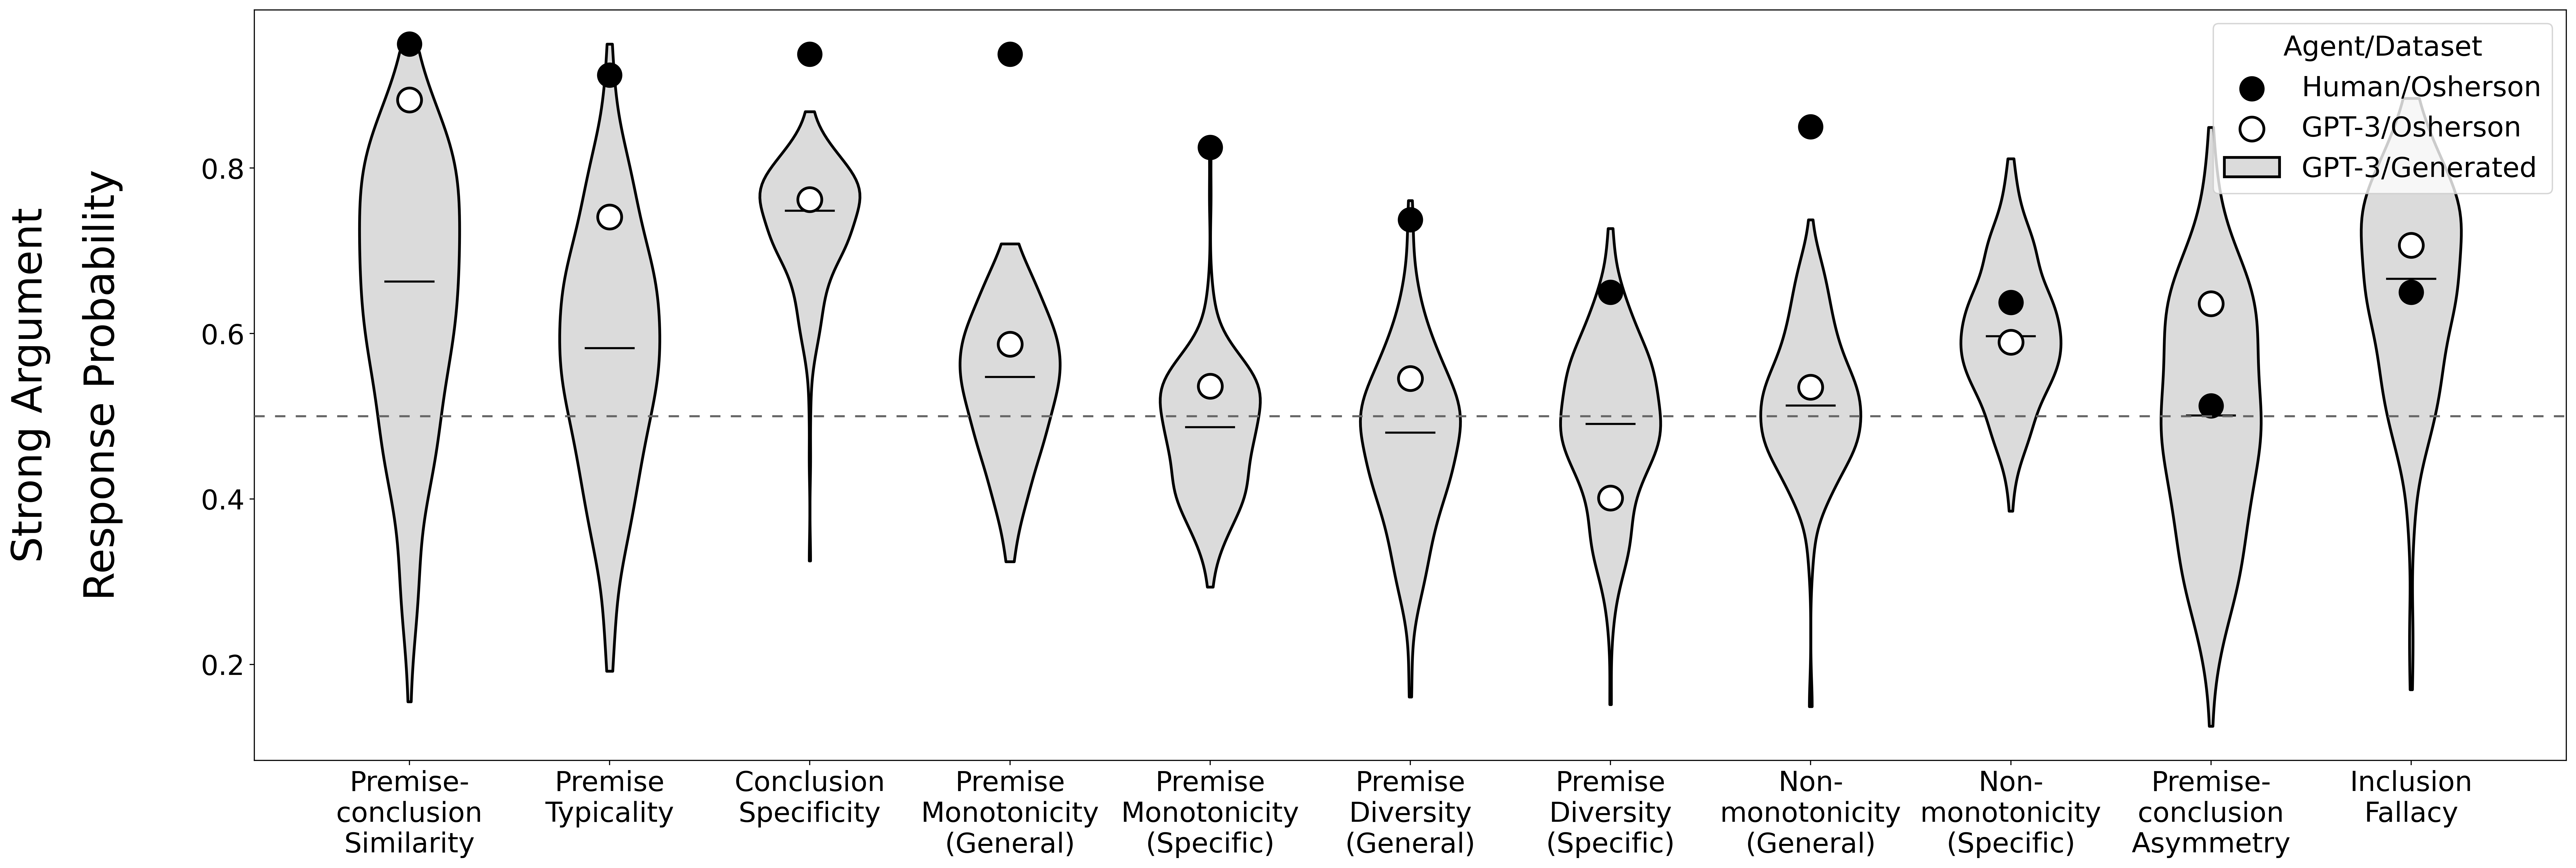

In [6]:
# Add a little bit to the asymmetry gpt3 prob so that it's visible
#gpt3_ratings_df["win_prob"] = [row["win_prob"] + 0.005 if row["phenomenon_number"] == 8 else row["win_prob"] for _, row in gpt3_ratings_df.iterrows()]

# Func to draw line segment
def newline(p1, p2):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='#4d4d4d', linewidth=0, zorder=2)
    ax.add_line(l)
    return l

fig, ax = plt.subplots(1,1,figsize=(30,10), dpi= 400)

# Line Segments
for i, p1, p2 in zip(human_ratings_df["phenomenon_order"], human_ratings_df["win_prob"], gpt3_ratings_df["win_prob"]):
    newline([i, p1], [i, p2])

# Points
s1 = ax.scatter(x=human_ratings_df["phenomenon_order"], y=human_ratings_df["win_prob"], s=300, color='#000000', alpha=1, zorder=3)
s2 = ax.scatter(x=gpt3_ratings_df["phenomenon_order"], y=gpt3_ratings_df["win_prob"], s=300, color='#ffffff', edgecolors='#000000', linewidths=2, alpha=1, zorder=3)

# Violins
violin_parts = ax.violinplot(dataset=[tdf["win_prob"] for pn, tdf in gpt3_artificial_ratings_df.groupby("phenomenon_order")], vert=True, showmedians=True, showextrema=False)
for pc in violin_parts['bodies']:
    pc.set_alpha(1)
    pc.set_color('#dbdbdb')
    pc.set_edgecolor('#000000')
    pc.set_linewidth(2)
violin_parts["cmedians"].set_color('#000000')
violin_parts["cmedians"].set_snap(True)

# Horizontal dashed line at 0.5
ax.axhline(y=0.5, dashes=(5,5), color='#666666', zorder=4)

# Labels and titles
ax.set_xticks(list(range(1,12)))
ax.set_xticklabels([p.replace("-", "-\n").replace("Non", "Non-\n") for p in gpt3_ratings_df["phenomenon"].tolist()])
#ax.set_xlabel("\nPhenomenon", linespacing=2, fontsize=30)
ax.set_ylabel("Strong Argument\nResponse Probability\n", linespacing=2, fontsize=30)

# Readability 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Legend
ax.legend([s1, s2, violin_parts["bodies"][0]], ['Human/Osherson', 'GPT-3/Osherson', 'GPT-3/Generated'], title="Agent/Dataset", title_fontsize=20, fontsize=20)

plt.savefig("figures/figure1", dpi=600)

# Fig 2: GPT-SCM/Human Correlation

In [5]:
# Get embeddings
embedding_df = pd.read_csv(config.figure_2bc_data_path, index_col=0)
embedding_df["embedding"] = embedding_df["embedding"].apply(eval).apply(np.array)
category2embedding = pd.Series(embedding_df["embedding"].tolist(), index=embedding_df["category"].tolist()).to_dict()
categories = embedding_df["category"].tolist()

In [9]:
CATEGORY_HIERARCHY = {
    "Animal": 3,
    "Mammal": 2,
    "Bird": 2,
    "Fish": 2,
    "Reptile": 2,
    "Insect": 2,
}

CLASS_LISTS = {
    "Mammal": categories[1:31],
    "Bird": categories[32:62],
    "Fish": categories[63:86],
    "Reptile": categories[114:-1],
    "Insect": categories[87:113],
}

PREMISE_NUMBERS = {
    1:"horse",
    2:"cow",
    3:"chimp",
    4:"gorilla",
    5:"mouse",
    6:"squirrel",
    7:"dolphin",
    8:"seal",
    9:"elephant",
    10:"rhino",
}

def get_category_class(category):
    for k,v in CLASS_LISTS.items():
        if category.capitalize() in v:
            return k
    return category.capitalize()

def get_category_hierarchy(category):
    if category in CATEGORY_HIERARCHY:
        return CATEGORY_HIERARCHY[category]
    else:
        return 1
        
def scm(premise_1, premise_2, premise_3, conclusion, category2embedding, alpha=0.25) -> float:
    
    if conclusion in PREMISE_NUMBERS.values():
        conclusion_categories = [conclusion]
    else:
        conclusion_categories = list(PREMISE_NUMBERS.values())
        
    a = np.mean([
        np.max([
            cosine_similarity([category2embedding[p]], [category2embedding[c_cat]])[0][0]
            for p in [premise_1, premise_2, premise_3] if p
        ])
        for c_cat in conclusion_categories
    ])
        
    # calculate b
    conclusion_categories = list(PREMISE_NUMBERS.values())
    b = np.mean([
            np.max([
                cosine_similarity([category2embedding[p]], [category2embedding[c_cat]])[0][0]
                for p in [premise_1, premise_2, premise_3] if p
            ])
            for c_cat in conclusion_categories
    ]) 
    
    return alpha*a + (1-alpha)*b

def get_human_strength_df(conclusion_type, category2embedding):
    df = pd.read_csv(config.figure_2a_data_path(conclusion_type), index_col=0)
    df["yes_prob"] = [np.exp(ylp) for ylp in df["yes_logprob"]]
    df["no_prob"] = [np.exp(ylp) for ylp in df["no_logprob"]]
    df["yes_prob"] = df["yes_prob"] / (df["yes_prob"] + df["no_prob"])

    # Load human strength ratings
    human_strength_df = helpers.read_osherson_ranked_arguments(conclusion_type)

    # Calculate SCM scores
    if conclusion_type == "specific":
        human_strength_df["gpt maxsim scm"] = [scm(row["premise_1"], row["premise_2"], "", row["conclusion"], category2embedding) for _, row in human_strength_df.iterrows()]
    else:
        human_strength_df["gpt maxsim scm"] = [scm(row["premise_1"], row["premise_2"], row["premise_3"], "all mammals", category2embedding, alpha=0.95) for _, row in human_strength_df.iterrows()]
        
    return df, human_strength_df

In [18]:
animal_correlation_df = correlation_df[correlation_df["Category"].isin(["Birds", "Fish", "Insects", "Mammals", "Reptiles"])].sort_values(by="Correlation", ascending=False)
other_correlation_df = correlation_df[~correlation_df["Category"].isin(["Birds", "Fish", "Insects", "Mammals", "Reptiles"])].sort_values(by="Correlation", ascending=False)

animal_correlation_df["Class"] = ["Animal"]*animal_correlation_df.shape[0]
other_correlation_df["Class"] = ["Other"]*other_correlation_df.shape[0]

correlation_df = pd.concat([animal_correlation_df, other_correlation_df])

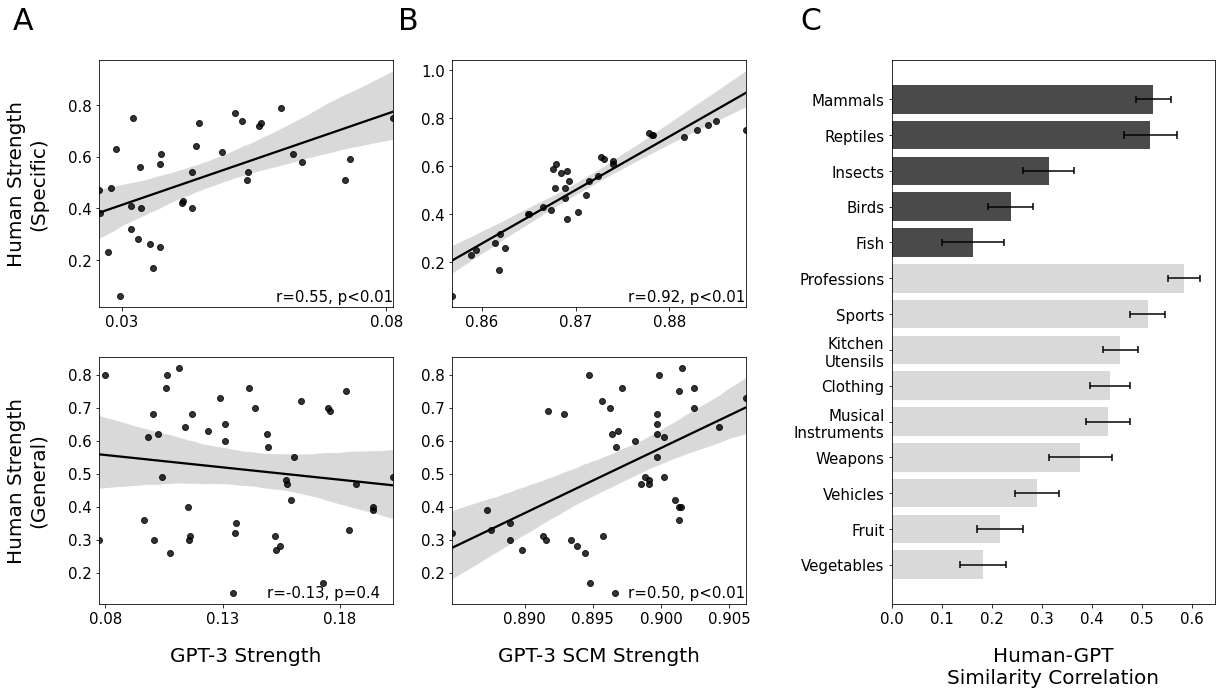

In [25]:
fig = plt.figure(figsize=(20,10))

gs0 = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[2,1], wspace=0.3)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[0,0])
ax2 = fig.add_subplot(gs00[0,1])
ax3 = fig.add_subplot(gs00[1,0])
ax4 = fig.add_subplot(gs00[1,1])

ax5 = fig.add_subplot(gs0[1])


# Plot argument correlations
sns.regplot(y=specific_human_strength_df["human_strength"], x=specific_df["yes_prob"], ax=ax1, scatter_kws={"color": "black"}, line_kws={"color": "black"})
sns.regplot(y="human_strength", x="gpt maxsim scm", data=specific_human_strength_df, ax=ax2, scatter_kws={"color": "black"}, line_kws={"color": "black"})

sns.regplot(y=general_human_strength_df["human_strength"], x=general_df["yes_prob"], ax=ax3, scatter_kws={"color": "black"}, line_kws={"color": "black"})
sns.regplot(y="human_strength", x="gpt maxsim scm", data=general_human_strength_df, ax=ax4, scatter_kws={"color": "black"}, line_kws={"color": "black"})

ax1.set_ylabel('Human Strength\n(Specific)', labelpad=20, fontsize=20)
ax3.set_ylabel('Human Strength\n(General)', labelpad=20, fontsize=20)

for ax in [ax1,ax2,ax3,ax4]:
    plt.setp(ax.get_xticklabels(), fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('GPT-3 Strength', labelpad=20, fontsize=20)
ax4.set_xlabel('GPT-3 SCM Strength', labelpad=20, fontsize=20)
ax2.set_ylabel('')
ax4.set_ylabel('')


r, p = stats.pearsonr(specific_df["yes_prob"], specific_human_strength_df["human_strength"])
ax1.text(.6, .025, 'r={:.2f}, p<0.01'.format(r, p), fontsize=15, transform=ax1.transAxes)
ax1.xaxis.set_ticks(np.arange(0.03, 0.09, 0.05))
r, p = stats.pearsonr(specific_human_strength_df["human_strength"], specific_human_strength_df["gpt maxsim scm"])
ax2.text(.6, .025, 'r={:.2f}, p<0.01'.format(r), fontsize=15, transform=ax2.transAxes)
ax2.xaxis.set_ticks(np.arange(0.86, 0.88, 0.01))

r, p = stats.pearsonr(general_df["yes_prob"], general_human_strength_df["human_strength"])
ax3.text(0.57, .025, 'r={:.2f}, p={:.2g}'.format(r, p), fontsize=15, transform=ax3.transAxes)
ax3.xaxis.set_ticks(np.arange(0.08, 0.2, 0.05))
r, p = stats.pearsonr(general_human_strength_df["human_strength"], general_human_strength_df["gpt maxsim scm"])
ax4.text(.6, .025, 'r={:.2f}, p<0.01'.format(r), fontsize=15, transform=ax4.transAxes)
ax4.xaxis.set_ticks(np.arange(0.89, 0.905, 0.005))

# Plot similarity correlations
bp = sns.barplot(y="Category", x="Correlation", palette=["#4a4a4a"]*animal_correlation_df.shape[0] + ["#d9d9d9"]*other_correlation_df.shape[0], data=correlation_df, ax=ax5)
# Add error bars
for i, row in correlation_df.reset_index(drop=True).iterrows():
    bp.errorbar(x=row["Correlation"],y=i,xerr=row["Standard Error"], ecolor="black") 
    bp.errorbar(x=row["Correlation"] - row["Standard Error"], y=i, yerr=0.1, ecolor="black")
    bp.errorbar(x=row["Correlation"] + row["Standard Error"], y=i, yerr=0.1, ecolor="black")
#ax5.invert_xaxis()
ax5.set_xlabel("Human-GPT\nSimilarity Correlation", labelpad=20, fontsize=20)
ax5.set_ylabel("", labelpad=30, fontsize=20)

for ax in (ax1, ax2, ax3, ax4, ax5):
    plt.setp(ax.get_yticklabels(), fontsize=15)
    plt.setp(ax.get_xticklabels(), fontsize=15)

ax1.set_title("A", x=-0.26, y=1.1, fontsize=30)
ax2.set_title("B", x=-0.15, y=1.1, fontsize=30)
ax5.set_title("C", x=-0.25, y=1.045, fontsize=30)

plt.savefig("figures/figure2.png", dpi=600)

# Fig 3: Argument strength correlations over models

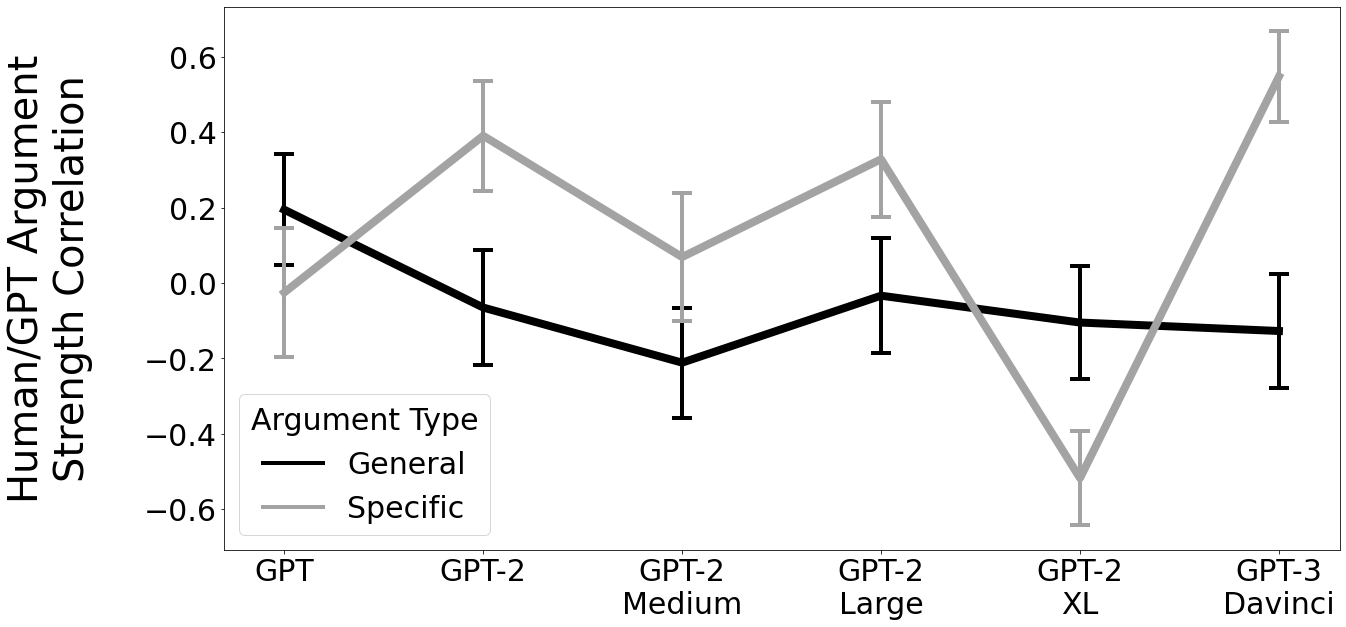

In [28]:
model_order = {
    "gpt": 1,
    "gpt2": 2,
    "gpt2-medium": 3,
    "gpt2-large": 4,
    "gpt2-xl": 5,
    "gpt3-davinci": 6
}

RENAME = {
    "gpt": "GPT",
    "gpt2": "GPT-2",
    "gpt2-medium": "GPT-2\nMedium",
    "gpt2-large": "GPT-2\nLarge",
    "gpt2-xl": "GPT-2\nXL",
    "gpt3-davinci": "GPT-3\nDavinci"
}

# Get GPT/human argument strength correlations
old_df = pd.read_csv(config.figure_3_data_path, index_col=0)
specific_gpt3_df, specific_human_strength_df = get_human_strength_df("specific", category2embedding)
general_gpt3_df, general_human_strength_df = get_human_strength_df("general", category2embedding)

human_strengths = {"specific": specific_human_strength_df, "general": general_human_strength_df}
gpt3_strengths = {"specific": specific_gpt3_df, "general": general_gpt3_df}

rows = []
for m_ct, tdf in old_df.groupby(["model", "conclusion_type"]):
    model, conclusion_type = m_ct
    r, p = stats.pearsonr(human_strengths[conclusion_type]["human_strength"], tdf["yes_prob"])
    se = (1 - r*r)/np.sqrt(tdf.shape[0] - 2)
    rows.append((model, conclusion_type.capitalize(), r, p, se))

for conclusion_type in human_strengths:
    r, p = stats.pearsonr(human_strengths[conclusion_type]["human_strength"], gpt3_strengths[conclusion_type]["yes_prob"])
    se = (1 - r*r)/np.sqrt(gpt3_strengths[conclusion_type].shape[0] - 2)
    rows.append(("gpt3-davinci", conclusion_type.capitalize(), r, p, se))
    
argument_correlation_df = pd.DataFrame(rows, columns=["model", "Argument Type", "human/model\ncorrelation strength", "p", "se"])
argument_correlation_df["model_order"] = argument_correlation_df["model"].apply(lambda x: model_order[x])
argument_correlation_df["model"] = argument_correlation_df["model"].apply(lambda x: RENAME[x])

fig, ax = plt.subplots(figsize=(20,10))
lp = sns.lineplot(x="model", y="human/model\ncorrelation strength", hue="Argument Type", data=argument_correlation_df.sort_values(by="model_order"), palette=["#000000", "#a3a3a3"], linewidth=8)

# Error bars
for model_name, model_num in model_order.items():
    i = model_num - 1
    general_row = argument_correlation_df[(argument_correlation_df["Argument Type"] == "General") & (argument_correlation_df["model"] == RENAME[model_name])]
    specific_row = argument_correlation_df[(argument_correlation_df["Argument Type"] == "Specific") & (argument_correlation_df["model"] == RENAME[model_name])]
    
    lp.errorbar(x=i,y=general_row["human/model\ncorrelation strength"].iloc[0],yerr=general_row["se"], ecolor="#000000", elinewidth=4)
    lp.errorbar(x=i, y=general_row["human/model\ncorrelation strength"].iloc[0]-general_row["se"], xerr=0.05, ecolor="#000000", elinewidth=4)
    lp.errorbar(x=i, y=general_row["human/model\ncorrelation strength"].iloc[0]+general_row["se"], xerr=0.05, ecolor="#000000", elinewidth=4)

    lp.errorbar(x=i,y=specific_row["human/model\ncorrelation strength"].iloc[0],yerr=specific_row["se"], ecolor="#a3a3a3", elinewidth=4)
    lp.errorbar(x=i, y=specific_row["human/model\ncorrelation strength"].iloc[0]-specific_row["se"], xerr=0.05, ecolor="#a3a3a3", elinewidth=4)
    lp.errorbar(x=i, y=specific_row["human/model\ncorrelation strength"].iloc[0]+specific_row["se"], xerr=0.05, ecolor="#a3a3a3", elinewidth=4)
    
#ax.set_xlabel("\nGPT Variant", fontsize=40)
ax.set_xlabel("", fontsize=40)
ax.set_ylabel("Human/GPT Argument\nStrength Correlation\n", fontsize=40)

plt.setp(ax.get_yticklabels(), fontsize=30)
plt.setp(ax.get_xticklabels(), fontsize=30)

leg = plt.legend(fontsize=30, title="Argument Type", title_fontsize=30)
for line in leg.get_lines():
    line.set_linewidth(4)
    
plt.savefig("figures/figure3.png", dpi=600)